1.1 Data preparation 

In [5]:
# Imports
import os
import torch
import torchvision
import numpy as np
from PIL import Image
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Custom Dataset
class DocumentDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [7]:
# DocumentClassifier Class
class DocumentClassifier:
    def __init__(self, num_classes):
        weights = models.ResNet50_Weights.DEFAULT
        self.baseline_model = models.resnet50(weights=weights)
        self.baseline_model.fc = nn.Linear(self.baseline_model.fc.in_features, num_classes)

        self.enhanced_model = models.resnet50(weights=weights)
        self.enhanced_model.fc = nn.Sequential(
            nn.BatchNorm1d(self.enhanced_model.fc.in_features),
            nn.Linear(self.enhanced_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


In [8]:
data_dir = '/Users/alimkhan/Downloads/capstone-main/aml_final/docs-sm'
image_paths = []
labels = []
class_names = ['specification', 'email', 'scientific_report', 'budget', 'scientific_publication', 'resume']

# Collect paths and labels
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(i)

# Train-Test Split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = DocumentDataset(train_paths, train_labels, transform)
test_dataset = DocumentDataset(test_paths, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Baseline Model

In [10]:
# Training Function
def train_model(model, train_loader, val_loader, epochs=10, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [11]:
# Plot Learning Curves
def plot_results(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


In [12]:
# Evaluation Function
def evaluate_model(model, test_loader, class_names, device='cpu'):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


Training Baseline Model...
Epoch 1/10:
Train Loss: 0.9845, Train Accuracy: 65.65%
Validation Loss: 0.9467, Validation Accuracy: 66.22%
Epoch 2/10:
Train Loss: 0.6014, Train Accuracy: 78.96%
Validation Loss: 0.7204, Validation Accuracy: 72.34%
Epoch 3/10:
Train Loss: 0.4248, Train Accuracy: 85.55%
Validation Loss: 1.7009, Validation Accuracy: 59.31%
Epoch 4/10:
Train Loss: 0.3241, Train Accuracy: 88.08%
Validation Loss: 0.7631, Validation Accuracy: 73.14%
Epoch 5/10:
Train Loss: 0.2199, Train Accuracy: 92.01%
Validation Loss: 0.8672, Validation Accuracy: 77.13%
Epoch 6/10:
Train Loss: 0.1732, Train Accuracy: 93.68%
Validation Loss: 0.9955, Validation Accuracy: 75.00%
Epoch 7/10:
Train Loss: 0.2810, Train Accuracy: 91.01%
Validation Loss: 1.0270, Validation Accuracy: 69.68%
Epoch 8/10:
Train Loss: 0.1536, Train Accuracy: 94.94%
Validation Loss: 0.6510, Validation Accuracy: 81.91%
Epoch 9/10:
Train Loss: 0.0585, Train Accuracy: 98.14%
Validation Loss: 0.6391, Validation Accuracy: 82.45%
E

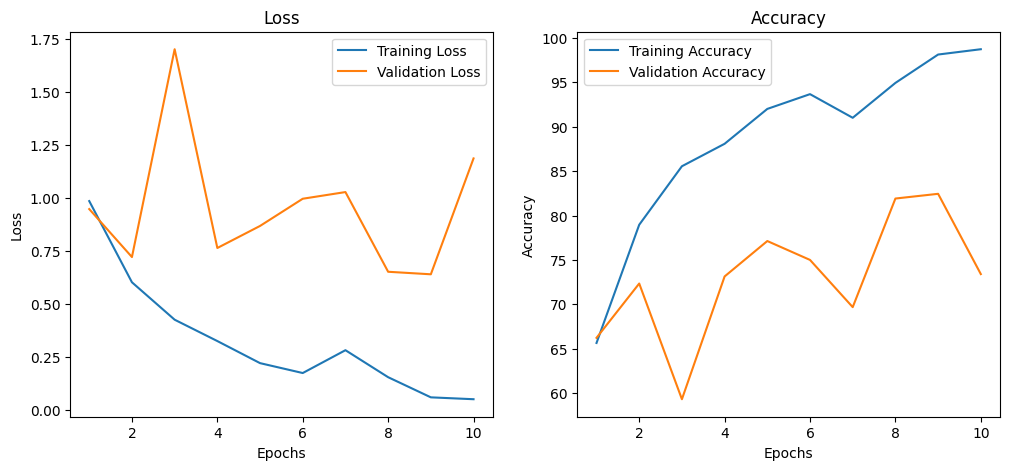

Evaluating Baseline Model...

Classification Report:
                        precision    recall  f1-score   support

         specification       0.61      0.84      0.71        56
                 email       0.94      0.89      0.91        71
     scientific_report       0.40      0.74      0.52        47
                budget       0.82      0.59      0.69        63
scientific_publication       0.92      0.82      0.87        68
                resume       1.00      0.54      0.70        71

              accuracy                           0.73       376
             macro avg       0.78      0.74      0.73       376
          weighted avg       0.81      0.73      0.75       376


Confusion Matrix:
[[47  0  7  2  0  0]
 [ 3 63  2  1  2  0]
 [ 8  0 35  3  1  0]
 [ 4  1 20 37  1  0]
 [ 2  1  7  2 56  0]
 [13  2 17  0  1 38]]
Training Enhanced Model...
Epoch 1/10:
Train Loss: 1.0273, Train Accuracy: 62.58%
Validation Loss: 0.8218, Validation Accuracy: 73.14%
Epoch 2/10:
Train Loss:

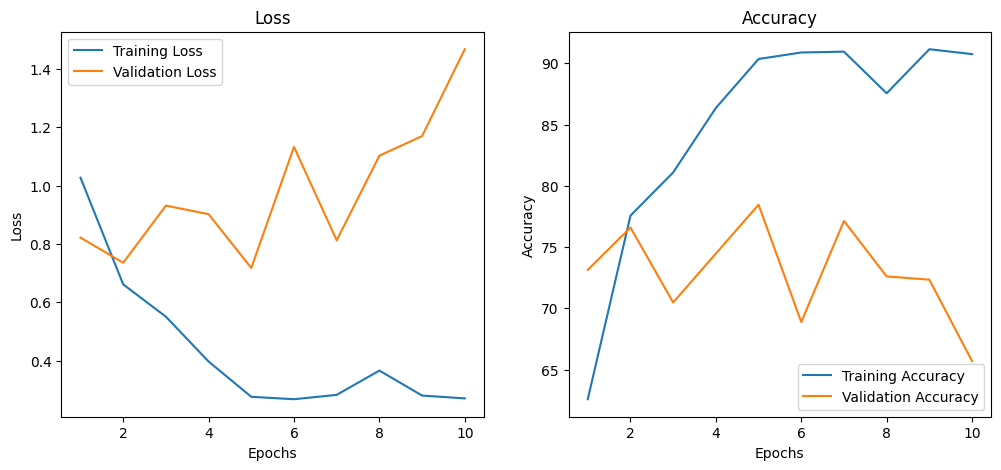

Evaluating Enhanced Model...

Classification Report:
                        precision    recall  f1-score   support

         specification       0.80      0.14      0.24        56
                 email       0.91      0.89      0.90        71
     scientific_report       0.35      0.94      0.51        47
                budget       0.64      0.71      0.68        63
scientific_publication       0.82      0.81      0.81        68
                resume       0.91      0.45      0.60        71

              accuracy                           0.66       376
             macro avg       0.74      0.66      0.62       376
          weighted avg       0.76      0.66      0.64       376


Confusion Matrix:
[[ 8  1 26 17  4  0]
 [ 0 63  2  2  2  2]
 [ 0  0 44  1  2  0]
 [ 2  1 14 45  1  0]
 [ 0  1  9  2 55  1]
 [ 0  3 30  3  3 32]]


In [13]:
# Run Training and Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Models
classifier = DocumentClassifier(num_classes=len(class_names))
baseline_model = classifier.baseline_model.to(device)
enhanced_model = classifier.enhanced_model.to(device)

# Train Baseline Model
print("Training Baseline Model...")
train_loss, val_loss, train_acc, val_acc = train_model(baseline_model, train_loader, test_loader, epochs=10, device=device)
plot_results(train_loss, val_loss, train_acc, val_acc)

# Evaluate Baseline Model
print("Evaluating Baseline Model...")
evaluate_model(baseline_model, test_loader, class_names, device)

# Train Enhanced Model
print("Training Enhanced Model...")
train_loss, val_loss, train_acc, val_acc = train_model(enhanced_model, train_loader, test_loader, epochs=10, device=device)
plot_results(train_loss, val_loss, train_acc, val_acc)

# Evaluate Enhanced Model
print("Evaluating Enhanced Model...")
evaluate_model(enhanced_model, test_loader, class_names, device)


In [15]:
# After training the enhanced model
torch.save(classifier.enhanced_model.state_dict(), 'enhanced_model.pth')

# Optional: Save the baseline model
torch.save(classifier.baseline_model.state_dict(), 'baseline_model.pth')


In [16]:
# Ensure the model architecture matches the one used during training
from torchvision import models
from torch import nn

# Define class names and model architecture
class_names = ['specification', 'email', 'scientific_report', 'budget', 'scientific_publication', 'resume']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate the enhanced model architecture
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)
model.load_state_dict(torch.load('enhanced_model.pth', map_location=device))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 